In [50]:
import sys, os
import datetime

pysbf_path = "/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/"
sys.path.insert(0, pysbf_path)
from pysbf import *

from IPython.display import display, Markdown, clear_output
warnings.filterwarnings('ignore')

In [51]:
inFolder = './data/wfc3/'
outFolder = './output/'
configFolder = pysbf_path + 'pysbf/config/'

In [52]:
name = "u12517"

outFolder += "Outputs_"+name+'/'
logFile = outFolder+name+"_model_log.csv"

In [53]:
df_log = open_log_df(logFile)
sky_med = float(df_log.loc["initial_sky_med"].value)

df = open_log_df(logFile)
obj_uuid = df.loc['uuid'].value
objRoot = outFolder+name+'_'+obj_uuid+'/'

X0 = float(df.loc['X0'].value)
Y0 = float(df.loc['Y0'].value)

Config = {} 

Config["name"] = name
Config["inFolder"] = inFolder
Config["objRoot"] = objRoot
Config["configFolder"] = configFolder
Config["X0"] = X0
Config["Y0"] = Y0
Config["SKY"] = df.loc["sky"].value

In [54]:
def pylike(like_pack, gclf_width=1.4, 
            distance=60, 
            bright_cutoff=20.5, 
            kscale=1.2,
            plot = False,
            **Config):
    
    name = Config["name"]
    inFolder = Config["inFolder"]
    objRoot = Config["objRoot"]
    lkn, lkn6, ptm6, resid = like_pack
    
    cwd = os.getcwd()
    xcmd("cp {}/{}/{}j.dmask {}.".format(inFolder, name, name, objRoot), verbose=True)
    os.chdir(objRoot)
    likenew = LikeNew(in_folder='./')
    likenew.run(gclf_width=gclf_width, 
                distance=distance, 
                bright_cutoff=bright_cutoff, 
                kscale=kscale,
                fname=lkn,
                mname="{}j.dmask".format(name),    # initial mask
                verbose=True
               )
    os.chdir(cwd)
    
    if plot:
        lkn6_name = os.path.join(objRoot, lkn6)
        header, tables, radii = read_lkn6(lkn6_name)
        _ = likenew_plot(lkn6_name, header, tables, radii)

In [9]:
def edit_ptm6_mask(like_pack, rad=5, self=False, **Config):
    
    objRoot = Config["objRoot"]
    lkn, lkn6, ptm6, resid = like_pack
    
    if self:
        infile = "{}b".format(ptm6)
    else:
        infile = ptm6
    
    cwd = os.getcwd()
    os.chdir(objRoot)
    
    if not os.path.exists(infile):
        xcmd("cp {} {}".format(ptm6, infile), verbose=True)
    
    
    monsta_script = """
        rd 1 """+resid+"""
        rd 2 '"""+infile+"""
        mi 2 1 
        tv 2 -1000 1000
        tidy 2 defer rad="""+str(rad)+"""
        di 2 2 
        wd 2 """+ptm6+"""b bitmap
    """
    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')
    now = datetime.now().strftime("%Y%m%d%H%M%S")
    xcmd("cp {}b {}b.{}".format(ptm6, ptm6, now), verbose=False)
    print("modified mask name: {}b".format(ptm6))
    print("time machine backup: {}b.{}".format(ptm6, now))
    os.chdir(cwd)
    
    return "{}b".format(ptm6)

In [55]:
def resid_ptm6(resid, all_masks, outfile=None, **Config):

    objRoot = Config["objRoot"]
    name = Config["name"]
    
    if outfile is None:
        outfile = "{}_resid_masked".format(name)
        
    cwd = os.getcwd()
    os.chdir(objRoot)
    monsta_script = """
        rd 1 """+resid
    
    
    for mask in all_masks:
        monsta_script+="""
        rd 2 """+mask+"""
        mi 1 2
        """
        
        
    monsta_script += """wd 1 """+outfile

    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')
    print("residual file ready for dophot: ", outfile)
    os.chdir(cwd)
    
    return outfile

In [56]:
def display_ptm6_mask(like_pack, **Config):
    
    objRoot = Config["objRoot"]
    lkn, lkn6, ptm6, resid = like_pack
    
    cwd = os.getcwd()
    os.chdir(objRoot)
    monsta_script = """
        rd 1 """+resid+"""
        rd 2 '"""+ptm6+"""
        mi 2 1 
        rd 3 '"""+ptm6+"""b
        mi 3 1
        tv 1 -1000 1000
        tv 2 -1000 1000
        tv 3 -1000 1000
        tidy 1 defer rad=5
    """
    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')
    os.chdir(cwd)

In [12]:
## renuc factors for Sextractor
## 100 Mpc renuc = 1.5
## 20 Mpc renuc = 7


In [57]:
avoiding_r = widgets.FloatSlider(
                    value=20,
                    min=1,
                    max=200,
                    step=1,
                    description="R_aperture",
                )

print("Radius of the avoding zone [pix]")
display(avoiding_r)

Radius of the avoding zone [pix]


FloatSlider(value=20.0, description='R_aperture', max=200.0, min=1.0, step=1.0)

In [58]:
# used Dmask instead of mask1
catalName, catal_df, se_objname, se_mask, se_masked, residual, segment = SE_foreground(model=0, 
                                       smooth=1.0, minArea=10, thresh=2.5,
                                       r_aperture = avoiding_r.value,   # [pixel] ignore objects within the aperture
                                       renuc=2, 
                                       Extended = False,
                                        **Config) 

catal_df.head()

./output/Outputs_u12517/u12517_9f43b1726bf2/obj.000.pro


,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,MAG_AUTO,MAGERR_AUTO,A_IMAGE,B_IMAGE,THETA_IMAGE,...,MAGERR_APER_1,MAGERR_APER_2,MAGERR_APER_3,MAGERR_APER_4,MAGERR_APER_5,MAG_ISO,MAGERR_ISO,MAG_ISOCOR,MAGERR_ISOCOR,rc
0,1,289.858,94.597,349.951975,43.962527,-14.4222,0.0018,1.795,1.643,77.2,...,0.0013,0.0,14439.2188,0.0,0.0,-14.4627,0.0022,-14.4795,0.0025,544.241387
1,2,866.618,37.736,349.972744,43.978395,-12.4509,0.0190,4.578,1.676,-87.3,...,0.0134,0.0,14439.2188,0.0,0.0,-12.2408,0.0127,-12.4227,0.0216,604.062241
2,3,17.345,37.746,349.939545,43.957126,-12.8564,0.0282,4.980,3.466,89.7,...,0.0470,0.0,14439.2188,0.0,0.0,-12.1968,0.0176,-12.8826,0.0305,760.461800
3,4,972.826,20.641,349.976362,43.981483,-13.2620,0.0062,3.152,1.850,-88.3,...,0.0043,0.0,14439.2188,0.0,0.0,-13.2610,0.0056,-13.3207,0.0078,676.696981
4,5,491.421,22.989,349.957612,43.969369,-11.0984,0.0362,2.602,1.067,64.0,...,0.0317,0.0,14439.2188,0.0,0.0,-10.8305,0.0264,-11.0683,0.0471,544.980902


In [59]:
segment

'./output/Outputs_u12517/u12517_9f43b1726bf2//objCheck.000.segment'

In [60]:
def ds9_scale_image(reg_file='./ds9.reg'):
    
    os.system("xpaset -p ds9 regions delete all &")
    os.system("xpaset -p ds9 regions "+reg_file+" &")

    # http://ds9.si.edu/doc/ref/xpa.html
    os.system("xpaset -p ds9 regions "+reg_file+" &")
    os.system("xpaset -p ds9 cmap value 7.9 0.47 &")

    # set image scale
    os.system("xpaset -p ds9 scale log &")
    os.system("xpaset -p ds9 scale limits -4100 200000 &")

## Ds9

Open ds9 and wait for its window to fully appear

In [61]:
print("se_mask: ", se_mask)
print("se_masked: ", se_masked)
print("residual: ", residual)
print("se_objname: ", se_objname)

# _ = CMD_button("ds9 "+se_mask+" &", "[DS9] se_mask")
# _ = CMD_button("ds9 "+se_masked+" &", "[DS9] se_masked")
_ = CMD_button("ds9 "+residual+" &", "[DS9] residual")
# _ = CMD_button("ds9 "+se_objname+" &", "[DS9] se_objname")

se_mask:  ./output/Outputs_u12517/u12517_9f43b1726bf2//mask_se.000
se_masked:  ./output/Outputs_u12517/u12517_9f43b1726bf2//masked_se.000
residual:  ./output/Outputs_u12517/u12517_9f43b1726bf2//resid.000
se_objname:  ./output/Outputs_u12517/u12517_9f43b1726bf2//objCheck.000


### Regions Guid

- green: extended opbject
- cyan: star, point source
- yellow: ignored or avoding zone

In [62]:
print("Radius of the avoding zone [pix]")
display(avoiding_r)

Radius of the avoding zone [pix]


FloatSlider(value=20.0, description='R_aperture', max=200.0, min=1.0, step=1.0)

In [63]:
catalName, catal_df, sex_objname, se_mask, se_masked, residual, segment = SE_foreground(
                                       model=0,
                                       smooth=1.0, minArea=5, thresh=2,
                                       r_aperture = avoiding_r.value,   # [pixel] ignore objects within the aperture
                                       renuc=2,
                                        **Config) 

lkn_file_name, ingore_id_list = make_se_lkn(catal_df, model=0, star_f=0.7, zp = 35.081,
                            r_aperture=avoiding_r.value, Extended=False,
                            **Config)

_ = CMD_button("ds9 "+residual+" &", "[DS9] residual")
reg_button = ds9_region_display(reg_file="./ds9.reg")
_ = Logtext(lkn_file_name, "lkn file")

resid = residual.rsplit('/', 1)[-1]
lkn = lkn_file_name.rsplit('/')[-1]
lkn6 = "{}j.lkn6".format(lkn.rsplit('.')[0])
ptm6 = "{}j.ptm6".format(lkn.rsplit('.')[0])

like_pack = (lkn, lkn6, ptm6, resid)

./output/Outputs_u12517/u12517_9f43b1726bf2/obj.000.pro
wrote:  ./output/Outputs_u12517/u12517_9f43b1726bf2/u12517_se_lknj.000
number of lines:  1091
# of GCs:  233
# of galaxies:  925


In [64]:
segment

'./output/Outputs_u12517/u12517_9f43b1726bf2//objCheck.000.segment'

In [21]:
## These are the ignored objects, not available int he LF list
## however we want to mask them. To do so we use the segmentation image created by ds9
# ingore_id_list

In [65]:
# if invert == True
# everywhere 1
# msked object 0
_ = seg2mask(segment, "test.fits", good_segments=ingore_id_list, invert=True)

In [23]:
# !ds9 test.fits 

In [66]:
like_pack

('u12517_se_lknj.000',
 'u12517_se_lknjj.lkn6',
 'u12517_se_lknjj.ptm6',
 'resid.000')


cp ./data/wfc3//u12517/u12517j.dmask ./output/Outputs_u12517/u12517_9f43b1726bf2/.
Beta  =	      4.3938e-01 	 #gxy / total sources

Cnorm =	      6.0583e-02 	 GC normalization
Cmax  =	      25.644 		 GC peak magnitude
Delta =	      1.4 		 GC distribution width
Alpha =	      0.990 		 GC log slope vs log r
Total # GC =  370.6

Gamma =	      0.25000 		 Gxy log slope vs m
Gnorm =	      1.76670 		 Gxy count / 1/" @ 34.50
Tnorm =	      0.14274 		 Tyson Gxy count @ 30.13
Total # gxy =  290.4


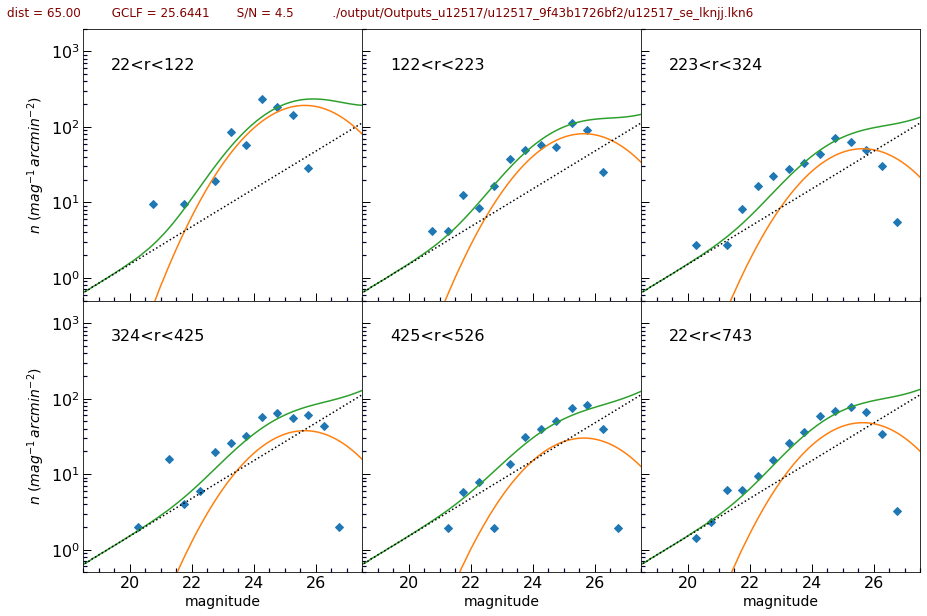

In [67]:
pylike(like_pack, 
            gclf_width=1.4, 
            distance=65, 
            bright_cutoff=21, 
            kscale=1.2, plot=True,
            **Config)

# code to display the button
_ = Logtext(os.path.join(objRoot, "{}j.lkn6".format(lkn.rsplit('.')[0])), "lkn6")

## Tidy commands

to edit the filter mask

In [68]:
ptm6

'u12517_se_lknjj.ptm6'

residual file ready for dophot:  test.000


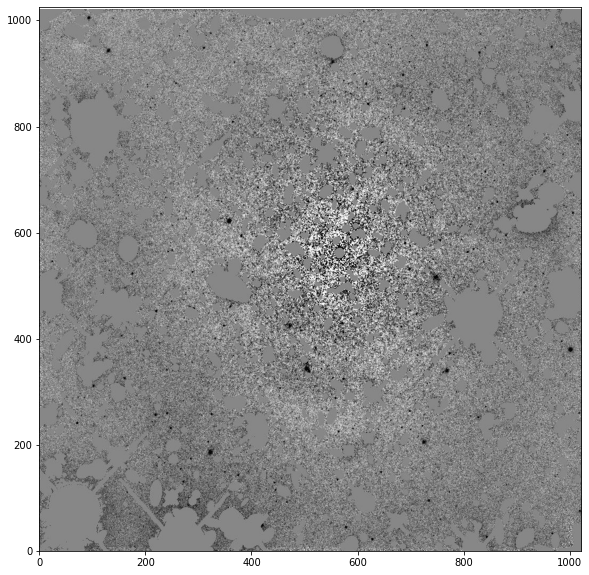

In [69]:
outfile = resid_ptm6(resid, [ptm6, "test.fits"], outfile='test.000', **Config)
# outfile = resid_ptm6(resid, [ptm6], outfile='test.000', **Config)
tv(os.path.join(objRoot, outfile))

In [70]:
! ds9 {Config["objRoot"]}/test.000 

<img src="img/tidy.jpg" alt="Alternative text" />

In [71]:
# press 'x' to edit
# press 'e' to save
edit_ptm6_mask(like_pack, self=True, rad=5, **Config)

modified mask name: u12517_se_lknjj.ptm6b
time machine backup: u12517_se_lknjj.ptm6b.20230206135758


'u12517_se_lknjj.ptm6b'

## display

3 frames
- residual
- ptm6
- ptm6b

In [72]:
display_ptm6_mask(like_pack, **Config)

# Hybrid

In [73]:
catalName, catal_df, sex_objname, se_mask, se_masked, residual, segment = SE_foreground(
                                       model=0,
                                       smooth=1.0, minArea=5, thresh=2.0,
                                       r_aperture = avoiding_r.value,   # [pixel] ignore objects within the aperture
                                       renuc=2,
                                        **Config) 

lkn_file_name, ingore_id_list = make_se_lkn(catal_df, model=0, star_f=0.7, zp = 35.081,
                            r_aperture=avoiding_r.value, Extended=True, sfx='segal',
                            **Config)

_ = CMD_button("ds9 "+residual+" &", "[DS9] residual")
reg_button = ds9_region_display(reg_file="./ds9.reg")
_ = Logtext(lkn_file_name, "lkn file")

resid = residual.rsplit('/', 1)[-1]
lkn_segal = lkn_file_name.rsplit('/')[-1]
lkn6 = "{}j.lkn6".format(lkn_segal.rsplit('.')[0])
ptm6 = "{}j.ptm6".format(lkn_segal.rsplit('.')[0])

like_pack = (lkn_segal, lkn6, ptm6, resid)


./output/Outputs_u12517/u12517_9f43b1726bf2/obj.000.pro
wrote:  ./output/Outputs_u12517/u12517_9f43b1726bf2/u12517_segal_lknj.000
number of lines:  874
# of GCs:  233
# of galaxies:  925


In [74]:
def update_ptm6(ptm6, all_masks, outfile=None, **Config):

    objRoot = Config["objRoot"]
    name = Config["name"]
    
    if outfile is None:
        outfile = "{}_updated.ptm6b".format(name)
        
    cwd = os.getcwd()
    os.chdir(objRoot)
    monsta_script = """
        rd 1 """+ptm6
    
    
    for mask in all_masks:
        monsta_script+="""
        rd 2 """+mask+"""
        mi 1 2
        """
        
    monsta_script += """di 1 1
    """
    monsta_script += """wd 1 """+outfile+""" bitmap
    """

    run_monsta(monsta_script, 'monsta.pro', 'monsta.log')
    print("residual file ready for dophot: ", outfile)
    os.chdir(cwd)
    
    return outfile

In [75]:
ptm6

'u12517_segal_lknjj.ptm6'

In [76]:
like_pack

('u12517_segal_lknj.000',
 'u12517_segal_lknjj.lkn6',
 'u12517_segal_lknjj.ptm6',
 'resid.000')

In [77]:
pylike(like_pack, 
            gclf_width=1.4, 
            distance=60, 
            bright_cutoff=20.5, 
            kscale=1.2, plot=False,
            **Config)


cp ./data/wfc3//u12517/u12517j.dmask ./output/Outputs_u12517/u12517_9f43b1726bf2/.
Beta  =	      3.8058e-01 	 #gxy / total sources

Cnorm =	      3.6971e-02 	 GC normalization
Cmax  =	      25.470 		 GC peak magnitude
Delta =	      1.4 		 GC distribution width
Alpha =	      0.897 		 GC log slope vs log r
Total # GC =  409.4

Gamma =	      0.25000 		 Gxy log slope vs m
Gnorm =	      1.53026 		 Gxy count / 1/" @ 34.50
Tnorm =	      0.12363 		 Tyson Gxy count @ 30.13
Total # gxy =  251.6


In [78]:
# if invert == True
# everywhere 1
# msked object 0
_ = seg2mask(segment, "test.fits", good_segments=ingore_id_list, invert=True)

residual file ready for dophot:  test.000


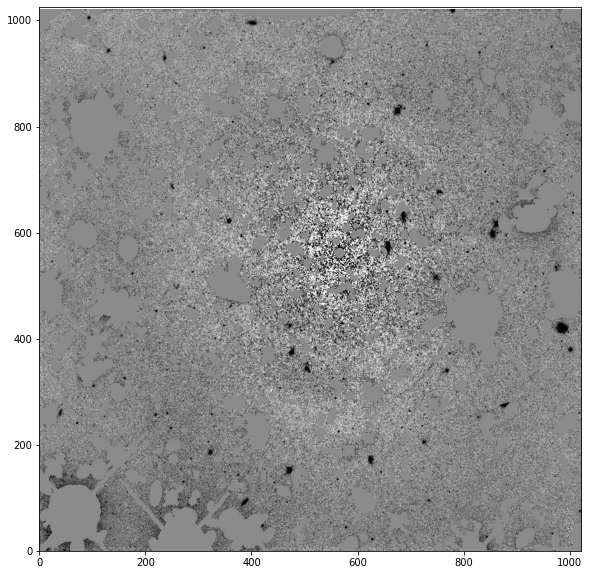

In [79]:
# outfile = resid_ptm6(resid, [ptm6, "test.fits"], outfile='test.000', **Config)
outfile = resid_ptm6(resid, [ptm6], outfile='test.000', **Config)
tv(os.path.join(objRoot, outfile))

In [80]:
outfile = update_ptm6(ptm6, ["test.fits"], outfile=ptm6, **Config)

residual file ready for dophot:  u12517_segal_lknjj.ptm6


In [82]:
edit_ptm6_mask(like_pack, self=False, rad=5, **Config)

modified mask name: u12517_segal_lknjj.ptm6b
time machine backup: u12517_segal_lknjj.ptm6b.20230206135911


'u12517_segal_lknjj.ptm6b'

In [83]:
do_resid_image = resid_ptm6(resid, [ptm6+"b"], outfile="{}.2dophot".format(resid), **Config)
do_resid_image

residual file ready for dophot:  resid.000.2dophot


'resid.000.2dophot'

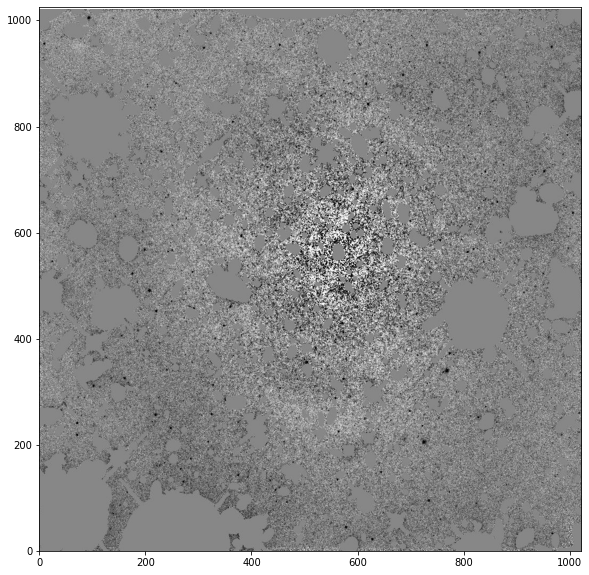

In [41]:
tv(os.path.join(objRoot, do_resid_image))

In [42]:
# used Dmask instead of mask1
log, resid_file, dpar_file, image_in, image_out, dpo_file = DoPhot(model=0, renuc=2, 
                                                                   image_in = do_resid_image,
                                                                   object_out = "{}.hybrid.dpo".format(name),
                                                                   **Config) 

# print("log file: ", log)
_ = Logtext(log, "log")

# print("dpar file: ", dpar_file)
_ = Logtext(dpar_file, "Dpar File")

if os.path.exists(image_in):
    print("input image: ", image_in)
    _ = CMD_button("ds9 "+image_in+" &", "[DS9] input image")
else:
    print("input image not found: ", image_in)

# if os.path.exists(resid_file):
#     print("residual image: ", resid_file)
#     _ = CMD_button("ds9 "+resid_file+" &", "[DS9] residual image")
# else:
#     print("residual image not found: ", resid_file)

print("dpo file: ", dpo_file)
if dpo_file is not None:
    _ = Logtext(dpo_file, "DPO File")
    
# print("output image: ", image_out)
# if image_out is not None:
#     _ = CMD_button("ds9 "+image_out+" &", "[DS9] dpr image")

reg_button = ds9_region_display(reg_file="./ds9.reg")

input image:  ./output/Outputs_u12517/u12517_9f43b1726bf2/resid.000.2dophot


dpo file:  ./output/Outputs_u12517/u12517_9f43b1726bf2/u12517.hybrid.dpo


In [43]:
print("Radius of the avoding zone [pix]")
display(avoiding_r)

Radius of the avoding zone [pix]


FloatSlider(value=20.0, description='R_aperture', max=200.0, min=1.0, step=1.0)

In [44]:
DF, lkn_dophot = make_do_lkn(dpo_file, model=0, r_aperture=avoiding_r.value, 
                                    exclude457=False, 
                                    ZP=35.081, 
                                    **Config)

_ = Logtext(lkn_dophot, "lkn file")

like_pack = (lkn_dophot, lkn6, ptm6, resid)

wrote:  ./output/Outputs_u12517/u12517_9f43b1726bf2/u12517_do_lkn.000
number of lines:  251
GCs:  135
galaxies:  10
Including dophot object types 4, 5, and 7


In [45]:
_ = Logtext(os.path.join(objRoot, lkn_segal), "segal")
_ = Logtext(os.path.join(objRoot, lkn_dophot), "dophot")

FileNotFoundError: [Errno 2] No such file or directory: './output/Outputs_u12517/u12517_9f43b1726bf2/./output/Outputs_u12517/u12517_9f43b1726bf2/u12517_do_lkn.000'

In [ ]:
segal = os.path.join(objRoot, lkn_segal)
dophot = os.path.join(objRoot, lkn_dophot)

with open(segal, "r") as f:
    with open(dophot, "r") as g:
        
        se_lines = f.readlines()
        do_lines = g.readlines()
        


In [ ]:
with open(os.path.join(objRoot, "hybrid.lknj"), "w") as f:
    
    for i in range(0, len(se_lines)):
        line = se_lines[i]
        f.write(line)
        
    for i in range(len(do_lines)):
        line = do_lines[i]
        f.write(line)
    
_ = Logtext(os.path.join(objRoot, "hybrid.lknj"), "hybrid")

In [ ]:
lkn = "hybrid.lknj"

lkn6 = "{}j.lkn6".format(lkn.rsplit('.')[0])
ptm6 = "{}j.ptm6".format(lkn.rsplit('.')[0])

like_pack = (lkn, lkn6, ptm6, "resid.000")

In [ ]:
like_pack

In [ ]:
pylike(like_pack, 
            gclf_width=1.4, 
            distance=80, 
            bright_cutoff=21, 
            kscale=1.2, plot=True,
            **Config)

_ = Logtext(os.path.join(objRoot, "hybridj.lkn6"), "hybrid")

In [ ]:
final_mask = edit_ptm6_mask(like_pack, self=True, rad=5, **Config)

residual file ready for dophot:  test.000


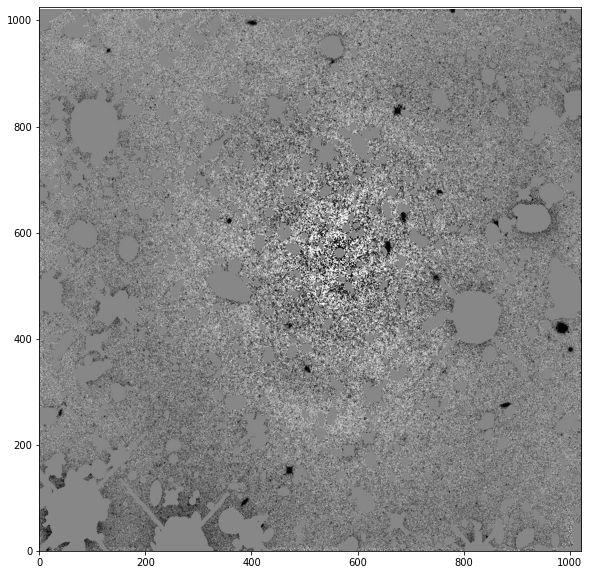

In [145]:
outfile = resid_ptm6(resid, [ptm6+"b"], outfile='test.000', **Config)

tv(os.path.join(objRoot, outfile))